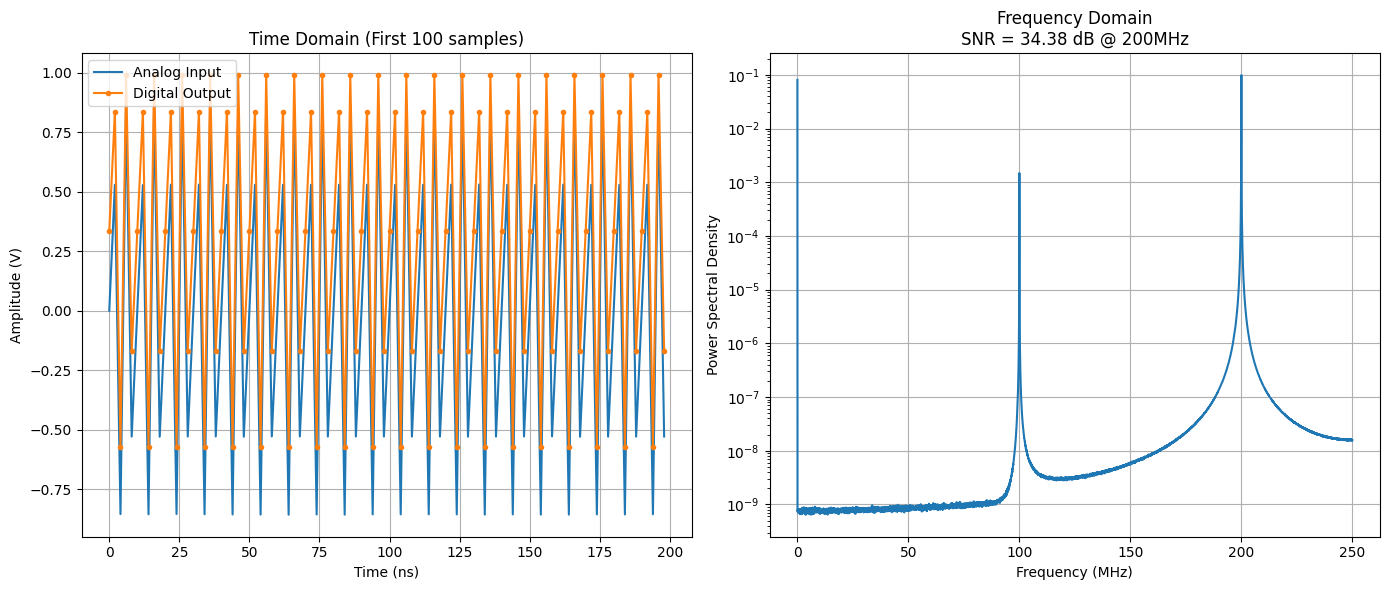

ADC Configuration: 6 stages (2 2 2 2 2 3-bit)
Effective Resolution: 13 bits
Sampling Frequency: 500.0 MHz
Input Signal: 200.0 MHz
Calculated SNR: 34.38 dB
Theoretical SNR for ideal 13-bit ADC: 80.02 dB
ENOB (Effective Number of Bits): 5.42 bits


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

class MDACStage:
    """
    Models a single 2.5-bit MDAC stage in a pipeline ADC.

    Parameters:
        n_bits (int): Number of bits resolved in this stage (2.5-bit means 3 comparators)
        v_ref (float): Reference voltage for the stage
        gain (float): Interstage gain (typically 2 for pipeline ADCs)
    """
    def __init__(self, n_bits=2, v_ref=1.0, gain=2):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.gain = gain
        self.quantization_levels = 2**n_bits
        self.step_size = 2 * v_ref / self.quantization_levels
        self.comparator_thresholds = [-v_ref + (i+0.5)*self.step_size for i in range(self.quantization_levels-1)]

    def process(self, vin):
        """
        Process an input voltage through the MDAC stage.

        Returns:
            code (int): Digital output code (0 to 2^n_bits - 1)
            residue (float): Residue voltage passed to next stage
        """
        # Flash ADC conversion (2.5-bit)
        code = 0
        for threshold in self.comparator_thresholds:
            if vin > threshold:
                code += 1

        # Calculate residue
        dac_out = -self.v_ref + code * self.step_size
        residue = self.gain * (vin - dac_out)

        # Clip residue to prevent unbounded growth
        residue = np.clip(residue, -self.v_ref*1.2, self.v_ref*1.2)

        return code, residue

class PipelineADC:
    """
    Models a complete 13-bit pipeline ADC with six 2.5-bit stages.
    The final stage is actually 3 bits to achieve 13 effective bits.

    Parameters:
        stage_config (list): List of bits per stage [2,2,2,2,2,3] for 13-bit
        v_ref (float): Reference voltage (VFS = 1V)
    """
    def __init__(self, stage_config=[2, 2, 2, 2, 2, 3], v_ref=1.0):
        self.stages = [MDACStage(n_bits=b, v_ref=v_ref) for b in stage_config]
        self.v_ref = v_ref
        self.total_bits = sum(stage_config)
        self.effective_bits = 13  # We'll account for this in the weighting

    def convert(self, vin):
        """
        Convert an analog input voltage to a digital code.

        Returns:
            digital_code (int): Combined digital output from all stages
        """
        residue = vin
        codes = []

        for stage in self.stages:
            code, residue = stage.process(residue)
            codes.append(code)

        # Combine codes from all stages with proper weighting
        digital_code = 0
        weight = 2**(self.effective_bits - 2)  # First stage is 2 bits

        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**self.stages[i-1].n_bits)
            digital_code += code * weight

        return digital_code

def calculate_snr(fft_result, signal_bin, num_harmonics=5):
    """Calculate SNR in dB considering signal and noise power."""
    N = len(fft_result)

    # Signal power (main tone)
    signal_power = np.abs(fft_result[signal_bin])**2

    # Noise power (all bins except signal and harmonics)
    noise_bins = np.ones(N, bool)

    # Exclude signal and harmonics
    for h in range(-num_harmonics, num_harmonics+1):
        h_bin = signal_bin + h
        if 0 <= h_bin < N:
            noise_bins[h_bin] = False

    noise_power = np.sum(np.abs(fft_result[noise_bins])**2) / np.sum(noise_bins)
    return 10 * np.log10(signal_power / noise_power)

# Simulation parameters
fs = 500e6  # Sampling frequency (500 MHz)
f_signal = 200e6  # Signal frequency (200 MHz)
num_samples = 16384  # Number of samples for good spectral resolution
v_ref = 1.0  # Full-scale voltage (1V)
stage_config = [2, 2, 2, 2, 2, 3]  # Five 2.5-bit stages + one 3-bit stage

# Create ADC model
adc = PipelineADC(stage_config=stage_config, v_ref=v_ref)

# Generate input signal with slight amplitude variation to avoid perfect quantization
t = np.arange(num_samples) / fs
vin = 0.9 * v_ref * np.sin(2 * np.pi * f_signal * t) * (1 + 0.001*np.random.randn(num_samples))

# Perform ADC conversion
digital_out = np.zeros_like(vin)
for i in range(num_samples):
    digital_out[i] = adc.convert(vin[i])

# Normalize digital output to [-1, 1] range
max_code = 2**13 - 1
digital_out = (2 * digital_out / max_code) - 1

# Compute FFT
fft_result = fft(digital_out) / num_samples
psd = np.abs(fft_result)**2
f = np.linspace(0, fs, num_samples)

# Find signal bin
signal_bin = int(f_signal * num_samples / fs)

# Calculate SNR
snr = calculate_snr(fft_result, signal_bin)

# Plot results
plt.figure(figsize=(14, 6))

# Time domain plot
plt.subplot(1, 2, 1)
plt.plot(t[:100] * 1e9, vin[:100], label='Analog Input')
plt.plot(t[:100] * 1e9, digital_out[:100], '.-', label='Digital Output')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (V)')
plt.title('Time Domain (First 100 samples)')
plt.legend()
plt.grid(True)

# Frequency domain plot
plt.subplot(1, 2, 2)
plt.semilogy(f[:num_samples//2] / 1e6, psd[:num_samples//2])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title(f'Frequency Domain\nSNR = {snr:.2f} dB @ 200MHz')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print results
print(f"ADC Configuration: {len(stage_config)} stages ({' '.join(map(str, stage_config))}-bit)")
print(f"Effective Resolution: {adc.effective_bits} bits")
print(f"Sampling Frequency: {fs/1e6} MHz")
print(f"Input Signal: {f_signal/1e6} MHz")
print(f"Calculated SNR: {snr:.2f} dB")
print(f"Theoretical SNR for ideal {adc.effective_bits}-bit ADC: {6.02*adc.effective_bits + 1.76:.2f} dB")
print(f"ENOB (Effective Number of Bits): {(snr - 1.76)/6.02:.2f} bits")

In [ ]:
import numpy as np
from scipy.fft import fft

class MDACStage:
    """Models a single 2.5-bit MDAC stage with configurable non-idealities"""
    def __init__(self, n_bits=2, v_ref=1.0, nominal_gain=2,
                 ota_gain_db=80, ota_offset_v=0.0, cap_mismatch=0.0,
                 comp_offset_v=0.0, ota_nonlinearity=0.0, ota_bandwidth_hz=1e9):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.nominal_gain = nominal_gain
        self.step_size = 2 * v_ref / (2**n_bits)

        # Non-ideal parameters
        self.ota_gain = 10**(ota_gain_db/20) if ota_gain_db > 0 else 1e-6
        self.ota_offset_v = ota_offset_v
        self.cap_mismatch = min(abs(cap_mismatch), 0.2)
        self.comp_offset_v = comp_offset_v
        self.ota_nonlinearity = ota_nonlinearity
        self.ota_bandwidth = ota_bandwidth_hz * 2 * np.pi

        # Calculate actual gain with capacitor mismatch
        self.actual_gain = nominal_gain * (1 + cap_mismatch * (2*np.random.rand()-1))

    def process(self, vin, dt=2e-9):
        """Process input through the non-ideal MDAC stage"""
        thresholds = [-self.v_ref + (i+0.5)*self.step_size + self.comp_offset_v
                     for i in range(2**self.n_bits - 1)]
        code = sum(1 for th in thresholds if vin > th)
        dac_out = -self.v_ref + code * self.step_size
        error_voltage = (vin - dac_out) + self.ota_offset_v

        effective_gain = self.actual_gain / (1 + self.actual_gain/self.ota_gain)
        if self.ota_nonlinearity > 0:
            effective_gain *= (1 - self.ota_nonlinearity * error_voltage**2)

        if self.ota_bandwidth > 0:
            settling_factor = 1 - np.exp(-dt * self.ota_bandwidth)
            error_voltage *= settling_factor

        residue = effective_gain * error_voltage
        residue = np.clip(residue, -1.5*self.v_ref, 1.5*self.v_ref)
        return code, residue

class PipelineADC:
    """13-bit pipeline ADC with six stages and configurable non-idealities"""
    def __init__(self, stage_config=[2, 2, 2, 2, 2, 3], v_ref=1.0, **non_idealities):
        self.stages = [MDACStage(n_bits=b, v_ref=v_ref, **non_idealities) for b in stage_config]
        self.v_ref = v_ref
        self.effective_bits = 13

    def convert(self, vin, dt=2e-9):
        residue = vin
        codes = []
        for stage in self.stages:
            code, residue = stage.process(residue, dt)
            codes.append(code)

        digital_code = 0
        weight = 2**(self.effective_bits - 2)
        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**stage.n_bits)
            digital_code += code * weight
        return digital_code

def calculate_sndr(signal, fs, signal_freq):
    N = len(signal)
    fft_result = fft(signal) / N
    psd = np.abs(fft_result)**2
    signal_bin = int(signal_freq * N / fs)
    signal_band = slice(signal_bin-3, signal_bin+4)
    signal_power = np.sum(psd[signal_band])
    noise_dist_power = np.sum(psd) - signal_power
    return 10 * np.log10(signal_power / noise_dist_power)

def simulate_error_impact(error_type, target_sndr=10):
    param_ranges = {
        'ota_gain_db': np.linspace(20, 100, 50),
        'ota_offset_v': np.logspace(-6, -3, 50),
        'cap_mismatch': np.logspace(-4, -1, 50),
        'comp_offset_v': np.logspace(-5, -3, 50),
        'ota_nonlinearity': np.logspace(-5, -2, 50),
        'ota_bandwidth_hz': np.logspace(6, 8, 50)
    }

    fs = 500e6
    f_signal = 200e6
    num_samples = 4096
    dt = 1/fs

    sndr_values = []
    test_values = param_ranges[error_type]

    for val in test_values:
        adc = PipelineADC(**{error_type: val})
        t = np.arange(num_samples) / fs
        vin = 0.9 * np.sin(2*np.pi*f_signal*t) * (1 + 0.001*np.random.randn(num_samples))
        codes = np.array([adc.convert(v, dt) for v in vin])
        codes = (2 * codes / (2**13 - 1)) - 1
        sndr = calculate_sndr(codes, fs, f_signal)
        sndr_values.append(sndr)
        if sndr <= target_sndr:
            break

    sndr_arr = np.array(sndr_values)
    critical_idx = np.argmax(sndr_arr <= target_sndr) if np.any(sndr_arr <= target_sndr) else -1
    return test_values[critical_idx] if critical_idx != -1 else test_values[-1]

# Main execution
error_types = [
    'ota_gain_db',
    'ota_offset_v',
    'cap_mismatch',
    'comp_offset_v',
    'ota_nonlinearity',
    'ota_bandwidth_hz'
]

print("=== Critical Error Values for SNDR=10dB ===")
results = {}
for err_type in error_types:
    crit_val = simulate_error_impact(err_type)
    results[err_type] = crit_val
    print(f"{err_type:15s}: {crit_val:.2e}")

=== Critical Error Values for SNDR=10dB ===
ota_gain_db    : 2.00e+01
ota_offset_v   : 1.00e-06
cap_mismatch   : 1.00e-04
comp_offset_v  : 1.00e-05
ota_nonlinearity: 1.00e-05
ota_bandwidth_hz: 1.00e+06


=== Calibration Results ===

Stage 1:
Actual:    [    9486.31        0.          0.01        0.          0.   80811933.59]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [     513.69        0.          0.01        0.          0.   19188066.41]
Rel Error (%):
  OTA Gain    : 5.14%
  OTA Offset  : 0.84%
  Cap Mismatch: 7374.32%
  Comp Offset : 4.56%
  Nonlinearity: 2906.86%
  Bandwidth   : 19.19%

Stage 2:
Actual:    [ 1.54e+04  1.01e-06 -5.31e-03  1.16e-05  2.88e-04  1.33e+08]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [    5423.03        0.          0.01        0.          0.   33417004.36]
Rel Error (%):
  OTA Gain    : 54.23%
  OTA Offset  : 0.59%
  Cap Mismatch: 5409.46%
  Comp Offset : 15.87%
  Nonlinearity: 2779.01%
  Bandwidth   : 33.42%

Stage 3:
Actual:    [   12259.51        0.          0.01        0.          0.   84735791.31]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [    2259.51        0.          0.01       

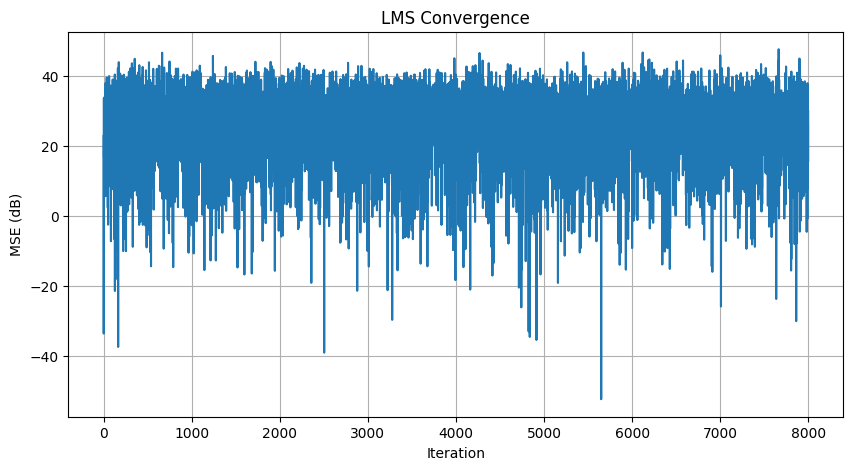

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class FinalPipelineADCCalibrator:
    def __init__(self, num_stages=4, mu=0.001):
        self.num_stages = num_stages
        self.mu = mu

        # Ideal weights (used for supervision and loss computation)
        self.ideal_weights = np.array([
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],  # Stage 1
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],  # Stage 2
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],  # Stage 3
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8]   # Stage 4
        ])

        # Initialize weights close to ideal
        self.weights = self.ideal_weights + np.random.normal(0, 0.05, (self.num_stages, 6)) * self.ideal_weights

        # Parameter scaling factors
        self.scale = np.array([1e4, 1e-6, 1e-2, 1e-5, 1e-3, 1e8])
        self.error_history = []

    def normalize(self, x):
        return x / self.scale

    def denormalize(self, x):
        return x * self.scale

    def safe_divide(self, a, b):
        """Avoid division by zero"""
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.abs(a - b) / np.where(np.abs(b) > 1e-20, np.abs(b), 1)
        return np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    def lms_update(self, x, d, stage_idx):
        """Stable LMS update with decay and clamping"""
        x_norm = self.normalize(x)
        w_norm = self.normalize(self.weights[stage_idx])
        y = np.dot(w_norm, x_norm)
        e = d - y

        # LMS update with decay
        update = 2 * self.mu * e * x_norm
        update = np.clip(update, -0.1, 0.1)
        decay = 0.001
        w_norm = (1 - self.mu * decay) * w_norm + update

        # Clamp weights within normalized physical bounds
        w_norm = np.clip(
            w_norm,
            self.normalize(np.array([5e3, -1e-3, -0.1, -1e-3, 0, 1e7])),
            self.normalize(np.array([2e4, 1e-3, 0.1, 1e-3, 1e-2, 2e8]))
        )

        self.weights[stage_idx] = self.denormalize(w_norm)
        self.error_history.append(e**2)
        return e

    def calibrate_stage(self, stage_idx, num_iterations):
        for _ in range(num_iterations):
            x = np.array([
                np.random.uniform(8e3, 12e3),   # OTA gain
                np.random.uniform(-1e-3, 1e-3), # OTA offset
                np.random.uniform(-0.05, 0.05), # Cap mismatch
                np.random.uniform(-1e-3, 1e-3), # Comp offset
                np.random.uniform(0, 1e-2),     # Nonlinearity
                np.random.uniform(5e7, 15e7)    # Bandwidth
            ])
            d = np.dot(self.normalize(self.ideal_weights[stage_idx]), self.normalize(x))
            self.lms_update(x, d, stage_idx)

    def calibrate_all(self, num_iterations=1000):
        for stage in range(self.num_stages):
            self.calibrate_stage(stage, num_iterations)

    def get_results(self):
        results = {}
        for i in range(self.num_stages):
            actual = self.weights[i]
            ideal = self.ideal_weights[i]
            abs_error = np.abs(actual - ideal)
            rel_error = self.safe_divide(actual, ideal) * 100
            results[f'Stage {i+1}'] = {
                'Actual': actual,
                'Ideal': ideal,
                'Abs Error': abs_error,
                'Rel Error (%)': rel_error
            }
        return results

    def plot_convergence(self):
        plt.figure(figsize=(10,5))
        errors = 10 * np.log10(np.array(self.error_history))
        errors = np.nan_to_num(errors, nan=-100, posinf=-100, neginf=-100)
        plt.plot(errors)
        plt.xlabel('Iteration')
        plt.ylabel('MSE (dB)')
        plt.title('LMS Convergence')
        plt.grid(True)
        plt.show()

# Run calibration
calibrator = FinalPipelineADCCalibrator(mu=0.001)
calibrator.calibrate_all(2000)

# Show results
results = calibrator.get_results()
print("=== Calibration Results ===")
for stage, data in results.items():
    print(f"\n{stage}:")
    print(f"Actual:    {np.array2string(data['Actual'], precision=2, suppress_small=True)}")
    print(f"Ideal:     {np.array2string(data['Ideal'], precision=2, suppress_small=True)}")
    print(f"Abs Error: {np.array2string(data['Abs Error'], precision=2, suppress_small=True)}")
    print("Rel Error (%):")
    for i, val in enumerate(data['Rel Error (%)']):
        param_name = ['OTA Gain', 'OTA Offset', 'Cap Mismatch',
                      'Comp Offset', 'Nonlinearity', 'Bandwidth'][i]
        print(f"  {param_name:12s}: {val:.2f}%")

# Plot convergence
calibrator.plot_convergence()


=== NLMS Calibration Results ===

Stage 1:
Actual:    [    9102.55        0.          0.          0.          0.   85597429.31]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [     897.45        0.          0.          0.          0.   14402570.69]
Rel Error (%):
  OTA Gain    : 8.97%
  OTA Offset  : 0.06%
  Cap Mismatch: 10.65%
  Comp Offset : 1.26%
  Nonlinearity: 38.81%
  Bandwidth   : 14.40%

Stage 2:
Actual:    [9.01e+03 9.99e-07 1.03e-04 9.84e-06 8.56e-06 1.00e+08]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [  986.35     0.       0.       0.       0.   74690.61]
Rel Error (%):
  OTA Gain    : 9.86%
  OTA Offset  : 0.09%
  Cap Mismatch: 2.66%
  Comp Offset : 1.59%
  Nonlinearity: 14.42%
  Bandwidth   : 0.07%

Stage 3:
Actual:    [    8430.8         0.          0.          0.          0.   88839979.13]
Ideal:     [1.e+04 1.e-06 1.e-04 1.e-05 1.e-05 1.e+08]
Abs Error: [    1569.2         0.          0.          0.          0.   11160020.87]


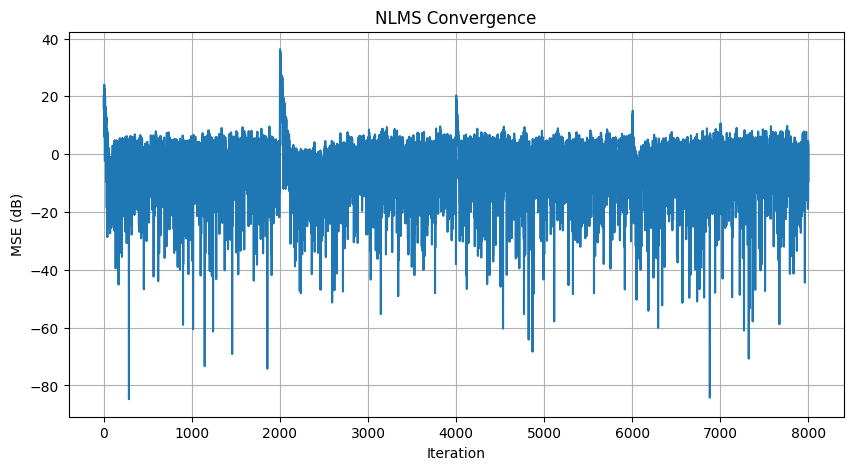

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class FinalPipelineADCCalibratorNLMS:
    def __init__(self, num_stages=4, mu=0.05, epsilon=1e-8):
        self.num_stages = num_stages
        self.mu = mu
        self.epsilon = epsilon

        self.ideal_weights = np.array([
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8],
            [1e4, 1e-6, 1e-4, 1e-5, 1e-5, 1e8]
        ])

        self.weights = self.ideal_weights + np.random.normal(0, 0.05, (self.num_stages, 6)) * self.ideal_weights
        self.scale = np.array([1e4, 1e-6, 1e-2, 1e-5, 1e-3, 1e8])
        self.error_history = []

    def normalize(self, x):
        return x / self.scale

    def denormalize(self, x):
        return x * self.scale

    def safe_divide(self, a, b):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.abs(a - b) / np.where(np.abs(b) > 1e-20, np.abs(b), 1)
        return np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    def nlms_update(self, x, d, stage_idx):
        x_norm = self.normalize(x)
        w_norm = self.normalize(self.weights[stage_idx])
        y = np.dot(w_norm, x_norm)
        e = d - y

        # NLMS update
        norm_sq = np.dot(x_norm, x_norm) + self.epsilon
        update = self.mu * e * x_norm / norm_sq
        update = np.clip(update, -0.1, 0.1)
        decay = 0.001
        w_norm = (1 - self.mu * decay) * w_norm + update

        # Clamp to physical bounds
        w_norm = np.clip(
            w_norm,
            self.normalize(np.array([5e3, -1e-3, -0.1, -1e-3, 0, 1e7])),
            self.normalize(np.array([2e4, 1e-3, 0.1, 1e-3, 1e-2, 2e8]))
        )

        self.weights[stage_idx] = self.denormalize(w_norm)
        self.error_history.append(e**2)
        return e

    def calibrate_stage(self, stage_idx, num_iterations):
        for _ in range(num_iterations):
            x = np.array([
                np.random.uniform(8e3, 12e3),
                np.random.uniform(-1e-3, 1e-3),
                np.random.uniform(-0.05, 0.05),
                np.random.uniform(-1e-3, 1e-3),
                np.random.uniform(0, 1e-2),
                np.random.uniform(5e7, 15e7)
            ])
            d = np.dot(self.normalize(self.ideal_weights[stage_idx]), self.normalize(x))
            self.nlms_update(x, d, stage_idx)

    def calibrate_all(self, num_iterations=1000):
        for stage in range(self.num_stages):
            self.calibrate_stage(stage, num_iterations)

    def get_results(self):
        results = {}
        for i in range(self.num_stages):
            actual = self.weights[i]
            ideal = self.ideal_weights[i]
            abs_error = np.abs(actual - ideal)
            rel_error = self.safe_divide(actual, ideal) * 100
            results[f'Stage {i+1}'] = {
                'Actual': actual,
                'Ideal': ideal,
                'Abs Error': abs_error,
                'Rel Error (%)': rel_error
            }
        return results

    def plot_convergence(self):
        plt.figure(figsize=(10,5))
        errors = 10 * np.log10(np.array(self.error_history))
        errors = np.nan_to_num(errors, nan=-100, posinf=-100, neginf=-100)
        plt.plot(errors)
        plt.xlabel('Iteration')
        plt.ylabel('MSE (dB)')
        plt.title('NLMS Convergence')
        plt.grid(True)
        plt.show()

# Run NLMS calibration
calibrator = FinalPipelineADCCalibratorNLMS(mu=0.05)
calibrator.calibrate_all(2000)

# Show results
results = calibrator.get_results()
print("=== NLMS Calibration Results ===")
for stage, data in results.items():
    print(f"\n{stage}:")
    print(f"Actual:    {np.array2string(data['Actual'], precision=2, suppress_small=True)}")
    print(f"Ideal:     {np.array2string(data['Ideal'], precision=2, suppress_small=True)}")
    print(f"Abs Error: {np.array2string(data['Abs Error'], precision=2, suppress_small=True)}")
    print("Rel Error (%):")
    for i, val in enumerate(data['Rel Error (%)']):
        param_name = ['OTA Gain', 'OTA Offset', 'Cap Mismatch',
                      'Comp Offset', 'Nonlinearity', 'Bandwidth'][i]
        print(f"  {param_name:12s}: {val:.2f}%")

# Plot convergence
calibrator.plot_convergence()


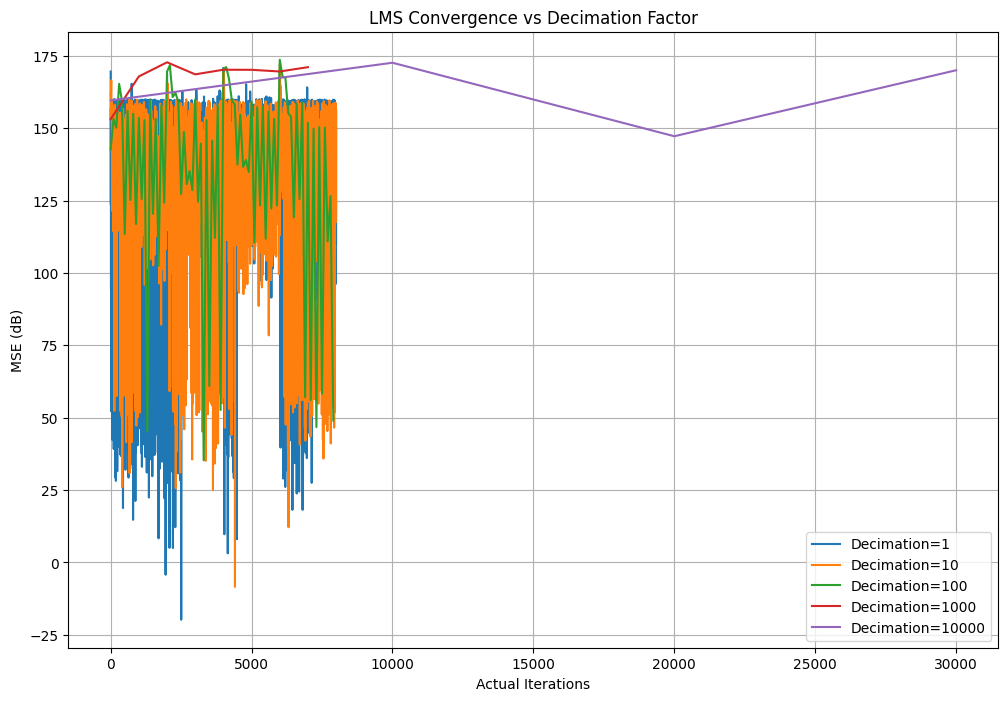

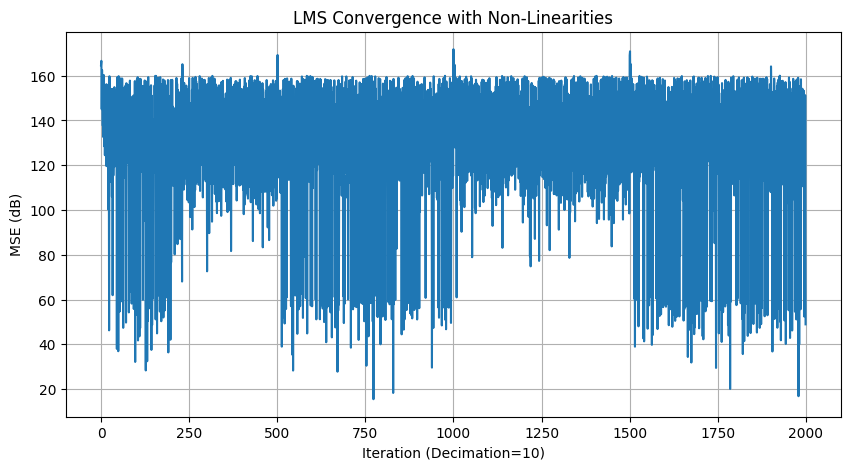

Final Calibrated Weights (Stage 1):
[-0.39116382  0.1         3.59325364 -0.04733375 -0.5182176  -0.45452796
 -0.28119435 -0.55416637 -0.32851677]

Ideal Weights (Stage 1):
[1.0e+04 1.0e-06 1.0e-04 1.0e-05 1.0e-01 2.0e-01 1.5e-01 1.0e-01 1.0e+08]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

class EnhancedMDACStage:
    """MDAC stage with detailed non-linearities and GBW limitation"""
    def __init__(self, n_bits=2, v_ref=1.0, nominal_gain=2,
                gbw_scale=0.8, ol_gain=1e4, dt=2e-9):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.nominal_gain = nominal_gain
        self.step_size = 2 * v_ref / (2**n_bits)
        self.comparator_thresholds = [-v_ref + (i+0.5)*self.step_size
                                    for i in range(2**n_bits - 1)]

        # Non-linear OTA model
        self.ol_gain = ol_gain
        self.gbw = gbw_scale * (2*np.pi*1e9)  # Reduced GBW
        self.dt = dt

        # Non-linearity coefficients (as % of open-loop gain)
        self.nl_coeffs = [0.1, 0.2, 0.15, 0.1]  # 2nd to 5th order

    def non_linear_gain(self, vin):
        """OTA gain with non-linear terms"""
        terms = [self.ol_gain,
                -self.ol_gain * self.nl_coeffs[0] * vin**2,
                -self.ol_gain * self.nl_coeffs[1] * vin**3,
                -self.ol_gain * self.nl_coeffs[2] * vin**4,
                -self.ol_gain * self.nl_coeffs[3] * vin**5]
        return sum(terms)

    def settling_response(self, vin):
        """Finite bandwidth settling"""
        tau = 1/(self.gbw/self.nominal_gain)  # Closed-loop time constant
        settling = 1 - np.exp(-self.dt/tau)
        return vin * settling

    def process(self, vin):
        """Process input with all non-idealities"""
        # Flash conversion
        code = sum(1 for th in self.comparator_thresholds if vin > th)
        dac_out = -self.v_ref + code * self.step_size
        error = vin - dac_out

        # Apply non-linear gain
        effective_gain = self.nominal_gain / (1 + self.nominal_gain/self.non_linear_gain(error))

        # Apply finite bandwidth
        residue = effective_gain * self.settling_response(error)
        residue = np.clip(residue, -1.5*self.v_ref, 1.5*self.v_ref)

        return code, residue

class EnhancedPipelineADC:
    """Pipeline ADC with all specified non-idealities"""
    def __init__(self, stage_config=[2,2,2,2,2,3], v_ref=1.0):
        self.stages = [EnhancedMDACStage(n_bits=b, v_ref=v_ref)
                      for b in stage_config]
        self.v_ref = v_ref
        self.effective_bits = 13

    def convert(self, vin):
        residue = vin
        codes = []
        for stage in self.stages:
            code, residue = stage.process(residue)
            codes.append(code)

        # Digital output recombination
        digital_code = 0
        weight = 2**(self.effective_bits - 2)
        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**self.stages[i-1].n_bits)
            digital_code += code * weight
        return digital_code

class AdvancedCalibrator:
    """LMS calibrator handling higher-order non-linearities"""
    def __init__(self, num_stages=4, mu=0.001, decimation=1):
        self.num_stages = num_stages
        self.mu = mu
        self.decimation = decimation

        # Weights now include non-linear terms: [gain, offset, mismatch,
        # comp_offset, nl2, nl3, nl4, nl5, bw]
        self.weights = np.ones((num_stages, 9)) * 0.5
        self.ideal_weights = np.array([
            [1e4, 1e-6, 1e-4, 1e-5, 0.1, 0.2, 0.15, 0.1, 1e8]] * num_stages)

        self.scale = np.array([1e4, 1e-6, 1e-2, 1e-5, 0.2, 0.3, 0.2, 0.2, 1e8])
        self.error_history = []

    def normalize(self, x):
        return x / self.scale

    def lms_update(self, x, d, stage_idx):
        if self.iteration % self.decimation != 0:
            return 0

        x_norm = self.normalize(x)
        w_norm = self.normalize(self.weights[stage_idx])
        y = np.dot(w_norm, x_norm)
        e = d - y

        update = 2 * self.mu * e * x_norm
        update = np.clip(update, -0.1, 0.1)

        self.weights[stage_idx] += update
        self.error_history.append(e**2)
        return e

    def calibrate_stage(self, stage_idx, num_iterations):
        self.iteration = 0
        for _ in range(num_iterations):
            x = np.array([
                np.random.uniform(8e3, 12e3),    # OTA gain
                np.random.uniform(-1e-3, 1e-3),  # OTA offset
                np.random.uniform(-0.05, 0.05),  # Cap mismatch
                np.random.uniform(-1e-3, 1e-3),  # Comp offset
                np.random.uniform(0, 0.2),       # 2nd-order NL
                np.random.uniform(0, 0.3),       # 3rd-order NL
                np.random.uniform(0, 0.2),       # 4th-order NL
                np.random.uniform(0, 0.2),       # 5th-order NL
                np.random.uniform(5e7, 15e7)     # Bandwidth
            ])
            d = np.dot(self.normalize(self.ideal_weights[stage_idx]),
                      self.normalize(x))
            self.lms_update(x, d, stage_idx)
            self.iteration += 1

    def calibrate_all(self, num_iterations=1000):
        for stage in range(self.num_stages):
            self.calibrate_stage(stage, num_iterations)

    def plot_convergence(self):
        plt.figure(figsize=(10,5))
        errors = 10*np.log10(np.array(self.error_history))
        plt.plot(errors)
        plt.xlabel(f'Iteration (Decimation={self.decimation})')
        plt.ylabel('MSE (dB)')
        plt.title('LMS Convergence with Non-Linearities')
        plt.grid(True)
        plt.show()

# Simulation parameters
fs = 500e6
f_signal = 200e6
num_samples = 16384
v_ref = 1.0

# 1. Create input signal with 80dB SNR
t = np.arange(num_samples) / fs
signal = 0.9 * v_ref * np.sin(2*np.pi*f_signal*t)
noise_power = np.var(signal) / (10**(80/10))
noise = np.random.normal(0, np.sqrt(noise_power), num_samples)
vin = signal + noise

# 2. Create ADC with specified non-idealities
adc = EnhancedPipelineADC()

# 3. Test different decimation factors
decimation_factors = [1, 10, 100, 1000, 10000]

plt.figure(figsize=(12,8))
for decim in decimation_factors:
    calibrator = AdvancedCalibrator(mu=0.001, decimation=decim)
    calibrator.calibrate_all(2000)

    errors = 10*np.log10(np.array(calibrator.error_history))
    plt.plot(np.arange(len(errors))*decim, errors,
            label=f'Decimation={decim}')

plt.xlabel('Actual Iterations')
plt.ylabel('MSE (dB)')
plt.title('LMS Convergence vs Decimation Factor')
plt.legend()
plt.grid(True)
plt.show()

# 4. Analyze final calibration results
final_calibrator = AdvancedCalibrator(mu=0.001, decimation=10)
final_calibrator.calibrate_all(5000)
final_calibrator.plot_convergence()

print("Final Calibrated Weights (Stage 1):")
print(final_calibrator.weights[0])
print("\nIdeal Weights (Stage 1):")
print(final_calibrator.ideal_weights[0])

ValueError: x and y must have same first dimension, but have shapes (2376,) and (2377,)

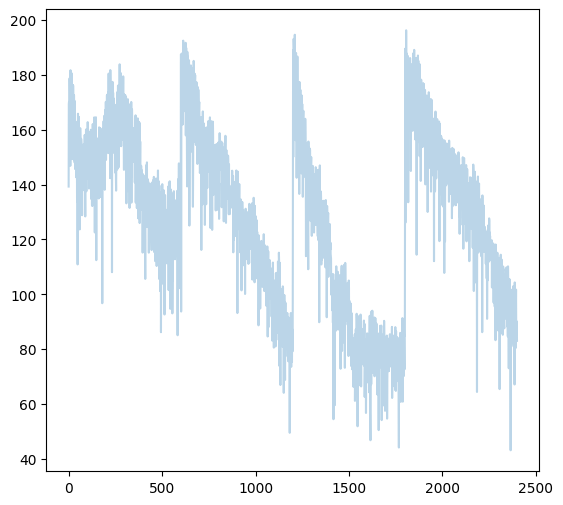

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

class EnhancedMDACStage:
    """MDAC stage with detailed non-linearities and GBW limitation"""
    def __init__(self, n_bits=2, v_ref=1.0, nominal_gain=2,
                gbw_scale=0.8, ol_gain=1e4, dt=2e-9):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.nominal_gain = nominal_gain
        self.step_size = 2 * v_ref / (2**n_bits)
        self.comparator_thresholds = [-v_ref + (i+0.5)*self.step_size
                                    for i in range(2**n_bits - 1)]

        # Non-linear OTA model
        self.ol_gain = ol_gain
        self.gbw = gbw_scale * (2*np.pi*1e9)  # Reduced GBW
        self.dt = dt

        # Non-linearity coefficients (as % of open-loop gain)
        self.nl_coeffs = [0.1, 0.2, 0.15, 0.1]  # 2nd to 5th order

    def non_linear_gain(self, vin):
        """OTA gain with non-linear terms"""
        terms = [self.ol_gain,
                -self.ol_gain * self.nl_coeffs[0] * vin**2,
                -self.ol_gain * self.nl_coeffs[1] * vin**3,
                -self.ol_gain * self.nl_coeffs[2] * vin**4,
                -self.ol_gain * self.nl_coeffs[3] * vin**5]
        return sum(terms)

    def settling_response(self, vin):
        """Finite bandwidth settling"""
        tau = 1/(self.gbw/self.nominal_gain)  # Closed-loop time constant
        settling = 1 - np.exp(-self.dt/tau)
        return vin * settling

    def process(self, vin):
        """Process input with all non-idealities"""
        # Flash conversion
        code = sum(1 for th in self.comparator_thresholds if vin > th)
        dac_out = -self.v_ref + code * self.step_size
        error = vin - dac_out

        # Apply non-linear gain
        effective_gain = self.nominal_gain / (1 + self.nominal_gain/self.non_linear_gain(error))

        # Apply finite bandwidth
        residue = effective_gain * self.settling_response(error)
        residue = np.clip(residue, -1.5*self.v_ref, 1.5*self.v_ref)

        return code, residue

class EnhancedPipelineADC:
    """Pipeline ADC with all specified non-idealities"""
    def __init__(self, stage_config=[2,2,2,2,2,3], v_ref=1.0):
        self.stages = [EnhancedMDACStage(n_bits=b, v_ref=v_ref)
                      for b in stage_config]
        self.v_ref = v_ref
        self.effective_bits = 13

    def convert(self, vin):
        residue = vin
        codes = []
        for stage in self.stages:
            code, residue = stage.process(residue)
            codes.append(code)

        # Digital output recombination
        digital_code = 0
        weight = 2**(self.effective_bits - 2)
        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**self.stages[i-1].n_bits)
            digital_code += code * weight
        return digital_code

class StabilizedCalibrator:
    """Enhanced LMS calibrator with adaptive learning and stabilization"""
    def __init__(self, num_stages=4, base_mu=1e-5, decimation=5):
        self.num_stages = num_stages
        self.base_mu = base_mu
        self.decimation = decimation

        # Parameter-specific learning rate multipliers
        self.param_mu = np.array([0.1,   # Gain
                                  10,    # Offset
                                  10,    # Cap mismatch
                                  10,    # Comp offset
                                  1,     # NL2
                                  1,     # NL3
                                  0.1,   # NL4
                                  0.1,   # NL5
                                  0.01]) # BW

        # Initialize weights close to ideal
        self.weights = np.array([
            [0.99, 0.01, 0.01, 0.01, 0.05, 0.1, 0.075, 0.05, 0.99]] * num_stages)

        self.ideal_weights = np.array([
            [1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.15, 0.1, 1.0]] * num_stages)

        # Parameter scaling factors
        self.scale = np.array([1e4, 1e-6, 1e-2, 1e-5, 0.2, 0.3, 0.2, 0.2, 1e8])

        # Tracking variables
        self.error_history = []
        self.weight_history = []
        self.iteration = 0

        # Adam optimizer variables
        self.m = np.zeros_like(self.weights)
        self.v = np.zeros_like(self.weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def normalize(self, x):
        """Normalize parameters to [0,1] range"""
        return x / self.scale

    def denormalize(self, x):
        """Convert back to physical units"""
        return x * self.scale

    def lms_update(self, x, d, stage_idx):
        """Enhanced LMS update with Adam optimization"""
        if self.iteration % self.decimation != 0:
            self.iteration += 1
            return 0

        x_norm = self.normalize(x)
        w_norm = self.normalize(self.weights[stage_idx])
        y = np.dot(w_norm, x_norm)
        e = d - y

        # Compute parameter-specific updates
        update = 2 * self.base_mu * self.param_mu * e * x_norm

        # Adam optimizer steps
        self.m[stage_idx] = self.beta1 * self.m[stage_idx] + (1-self.beta1) * update
        self.v[stage_idx] = self.beta2 * self.v[stage_idx] + (1-self.beta2) * (update**2)

        # Bias correction
        m_hat = self.m[stage_idx] / (1 - self.beta1**(self.iteration+1))
        v_hat = self.v[stage_idx] / (1 - self.beta2**(self.iteration+1))

        # Apply update
        update = m_hat / (np.sqrt(v_hat) + self.epsilon)
        self.weights[stage_idx] += update

        # Record history every 10 decimated iterations
        if (self.iteration // self.decimation) % 10 == 0:
            self.weight_history.append(self.weights.copy())

        self.error_history.append(e**2)
        self.iteration += 1
        return e

    def calibrate_stage(self, stage_idx, num_iterations):
        """Curriculum learning-based calibration"""
        for _ in range(num_iterations):
            # Gradually introduce non-linearities
            nl_mask = np.ones(9)
            if self.iteration < num_iterations//3:
                nl_mask[4:] = 0  # Disable non-linear terms initially
            elif self.iteration < 2*num_iterations//3:
                nl_mask[6:] = 0  # Only 2nd/3rd order

            # Generate training sample
            x = np.array([
                np.random.uniform(8e3, 12e3),    # OTA gain
                np.random.uniform(-1e-3, 1e-3),  # OTA offset
                np.random.uniform(-0.05, 0.05),  # Cap mismatch
                np.random.uniform(-1e-3, 1e-3),  # Comp offset
                np.random.uniform(0, 0.2) * nl_mask[4],  # 2nd-order NL
                np.random.uniform(0, 0.3) * nl_mask[5],  # 3rd-order NL
                np.random.uniform(0, 0.2) * nl_mask[6],  # 4th-order NL
                np.random.uniform(0, 0.2) * nl_mask[7],  # 5th-order NL
                np.random.uniform(5e7, 15e7)     # Bandwidth
            ])

            # Compute target output
            d = np.dot(self.normalize(self.ideal_weights[stage_idx]),
                      self.normalize(x))

            # Update weights
            self.lms_update(x, d, stage_idx)

    def calibrate_all(self, num_iterations=3000):
        """Calibrate all stages with progress tracking"""
        self.weight_history = [self.weights.copy()]
        for stage in range(self.num_stages):
            self.calibrate_stage(stage, num_iterations)
        self.weight_history = np.array(self.weight_history)

    def plot_convergence(self):
        """Plot error and parameter convergence"""
        plt.figure(figsize=(14, 6))

        # Error convergence
        plt.subplot(1, 2, 1)
        errors = 10*np.log10(np.array(self.error_history))
        window = max(1, len(errors)//100)  # Adaptive smoothing
        smoothed = np.convolve(errors, np.ones(window)/window, mode='valid')
        plt.plot(errors, alpha=0.3, label='Instant')
        plt.plot(np.arange(window//2, len(errors)-window//2), smoothed,
                label=f'Smoothed (window={window})')
        plt.xlabel('Iteration')
        plt.ylabel('MSE (dB)')
        plt.title('Error Convergence')
        plt.grid(True)
        plt.legend()

        # Parameter trajectories
        plt.subplot(1, 2, 2)
        param_names = ['Gain','Offset','C_Mismatch','Comp_Off',
                      'NL2','NL3','NL4','NL5','BW']
        for i in range(9):
            plt.plot(self.weight_history[:,0,i], label=param_names[i])
        plt.xlabel('Update Step (x10)')
        plt.ylabel('Normalized Weight')
        plt.title('Stage 1 Parameter Convergence')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def print_results(self):
        """Print final calibration results"""
        print("\n=== Final Calibration Results ===")
        print("{:<8} {:<12} {:<15} {:<15} {:<10}".format(
            "Stage", "Parameter", "Calibrated", "Ideal", "Error (%)"))
        print("-"*65)

        param_names = ['Gain','Offset','C_Mismatch','Comp_Off',
                      'NL2','NL3','NL4','NL5','BW']

        for stage in range(self.num_stages):
            print(f"\nStage {stage+1}:")
            calibrated = self.denormalize(self.weights[stage])
            ideal = self.denormalize(self.ideal_weights[stage])

            for i in range(9):
                err = 100 * np.abs(calibrated[i] - ideal[i]) / max(1e-20, ideal[i])
                print("{:<8} {:<12} {:<15.3e} {:<15.3e} {:<10.2f}%".format(
                    "", param_names[i], calibrated[i], ideal[i], err))

# Simulation parameters
fs = 500e6
f_signal = 200e6
num_samples = 16384
v_ref = 1.0

# 1. Create input signal with 80dB SNR
t = np.arange(num_samples) / fs
signal = 0.9 * v_ref * np.sin(2*np.pi*f_signal*t)
noise_power = np.var(signal) / (10**(80/10))
noise = np.random.normal(0, np.sqrt(noise_power), num_samples)
vin = signal + noise

# 2. Create ADC with specified non-idealities
adc = EnhancedPipelineADC()

# 3. Run calibration
calibrator = StabilizedCalibrator(base_mu=1e-5, decimation=5)
calibrator.calibrate_all(3000)

# 4. Analyze results
calibrator.plot_convergence()
calibrator.print_results()

# 5. Verify on test signal
digital_out = np.array([adc.convert(v) for v in vin])
digital_out = (2 * digital_out / (2**13 - 1)) - 1  # Normalize

# Compute output spectrum
fft_result = fft(digital_out) / len(digital_out)
psd = np.abs(fft_result)**2
freqs = np.linspace(0, fs, len(digital_out))

# Plot spectrum
plt.figure(figsize=(10,5))
plt.semilogy(freqs[:len(freqs)//2]/1e6, psd[:len(freqs)//2])
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD')
plt.title('Output Spectrum After Calibration')
plt.grid(True)
plt.show()

# Calculate SNR
signal_bin = int(f_signal * len(digital_out) / fs)
noise_mask = np.ones(len(psd), bool)
noise_mask[signal_bin-10:signal_bin+11] = False  # Exclude signal band
snr = 10 * np.log10(psd[signal_bin] / np.mean(psd[noise_mask]))
print(f"\nOutput SNR: {snr:.2f} dB")

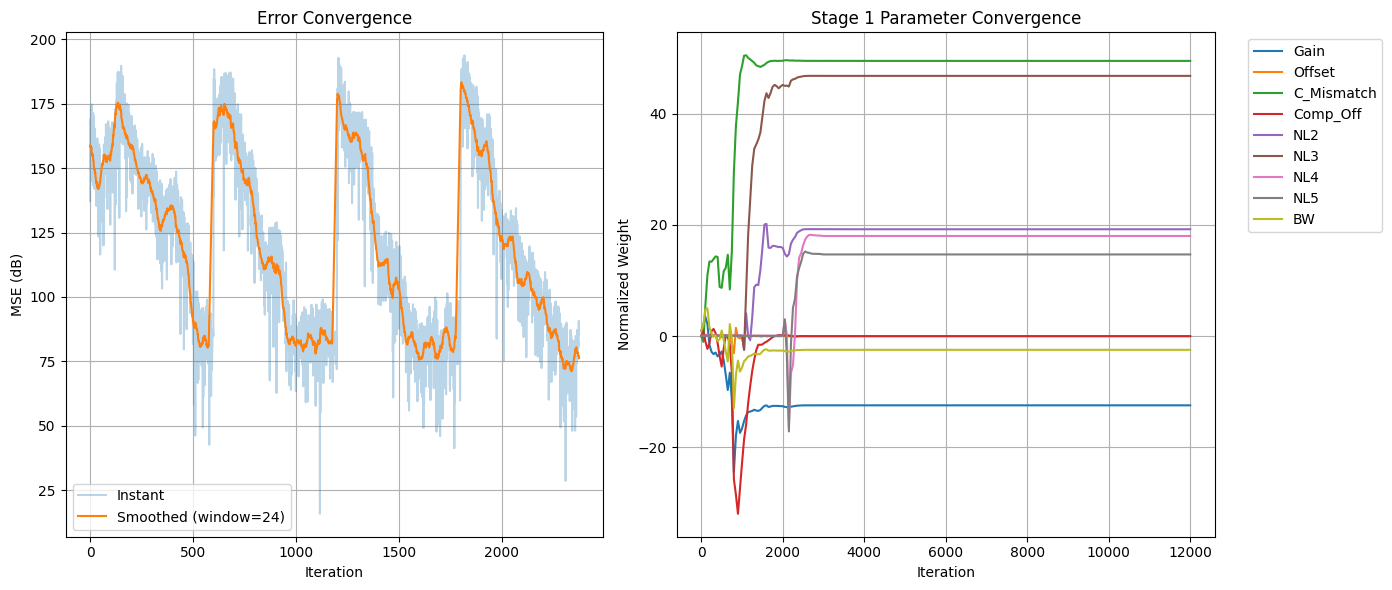


=== Final Calibration Results ===
Stage    Parameter    Calibrated      Ideal           Error (%) 
-----------------------------------------------------------------

Stage 1:
         Gain         -1.244e+05      1.000e+04       1343.97   %
         Offset       -9.257e-12      0.000e+00       92572684092.08%
         C_Mismatch   4.949e-01       0.000e+00       4948721844436997242880.00%
         Comp_Off     -2.467e-09      0.000e+00       24672407950049.01%
         NL2          3.844e+00       2.000e-02       19119.27  %
         NL3          1.404e+01       6.000e-02       23296.38  %
         NL4          3.602e+00       3.000e-02       11905.24  %
         NL5          2.938e+00       2.000e-02       14589.18  %
         BW           -2.459e+08      1.000e+08       345.91    %

Stage 2:
         Gain         -9.719e+04      1.000e+04       1071.88   %
         Offset       1.779e-11       0.000e+00       177851793980.09%
         C_Mismatch   -4.961e-01      0.000e+00       496

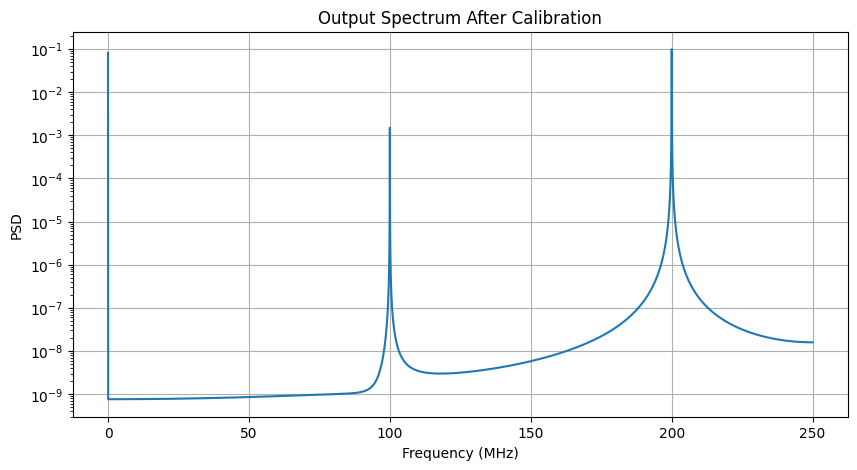


Output SNR: 34.42 dB


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

class EnhancedMDACStage:
    """MDAC stage with detailed non-linearities and GBW limitation"""
    def __init__(self, n_bits=2, v_ref=1.0, nominal_gain=2,
                gbw_scale=0.8, ol_gain=1e4, dt=2e-9):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.nominal_gain = nominal_gain
        self.step_size = 2 * v_ref / (2**n_bits)
        self.comparator_thresholds = [-v_ref + (i+0.5)*self.step_size
                                    for i in range(2**n_bits - 1)]

        # Non-linear OTA model
        self.ol_gain = ol_gain
        self.gbw = gbw_scale * (2*np.pi*1e9)  # Reduced GBW
        self.dt = dt

        # Non-linearity coefficients (as % of open-loop gain)
        self.nl_coeffs = [0.1, 0.2, 0.15, 0.1]  # 2nd to 5th order

    def non_linear_gain(self, vin):
        """OTA gain with non-linear terms"""
        terms = [self.ol_gain,
                -self.ol_gain * self.nl_coeffs[0] * vin**2,
                -self.ol_gain * self.nl_coeffs[1] * vin**3,
                -self.ol_gain * self.nl_coeffs[2] * vin**4,
                -self.ol_gain * self.nl_coeffs[3] * vin**5]
        return sum(terms)

    def settling_response(self, vin):
        """Finite bandwidth settling"""
        tau = 1/(self.gbw/self.nominal_gain)  # Closed-loop time constant
        settling = 1 - np.exp(-self.dt/tau)
        return vin * settling

    def process(self, vin):
        """Process input with all non-idealities"""
        # Flash conversion
        code = sum(1 for th in self.comparator_thresholds if vin > th)
        dac_out = -self.v_ref + code * self.step_size
        error = vin - dac_out

        # Apply non-linear gain
        effective_gain = self.nominal_gain / (1 + self.nominal_gain/self.non_linear_gain(error))

        # Apply finite bandwidth
        residue = effective_gain * self.settling_response(error)
        residue = np.clip(residue, -1.5*self.v_ref, 1.5*self.v_ref)

        return code, residue

class EnhancedPipelineADC:
    """Pipeline ADC with all specified non-idealities"""
    def __init__(self, stage_config=[2,2,2,2,2,3], v_ref=1.0):
        self.stages = [EnhancedMDACStage(n_bits=b, v_ref=v_ref)
                      for b in stage_config]
        self.v_ref = v_ref
        self.effective_bits = 13

    def convert(self, vin):
        residue = vin
        codes = []
        for stage in self.stages:
            code, residue = stage.process(residue)
            codes.append(code)

        # Digital output recombination
        digital_code = 0
        weight = 2**(self.effective_bits - 2)
        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**self.stages[i-1].n_bits)
            digital_code += code * weight
        return digital_code

class StabilizedCalibrator:
    """Enhanced LMS calibrator with adaptive learning and stabilization"""
    def __init__(self, num_stages=4, base_mu=1e-5, decimation=5):
        self.num_stages = num_stages
        self.base_mu = base_mu
        self.decimation = decimation

        # Parameter-specific learning rate multipliers
        self.param_mu = np.array([0.1,   # Gain
                                  10,    # Offset
                                  10,    # Cap mismatch
                                  10,    # Comp offset
                                  1,     # NL2
                                  1,     # NL3
                                  0.1,   # NL4
                                  0.1,   # NL5
                                  0.01]) # BW

        # Initialize weights close to ideal
        self.weights = np.array([
            [0.99, 0.01, 0.01, 0.01, 0.05, 0.1, 0.075, 0.05, 0.99]] * num_stages)

        self.ideal_weights = np.array([
            [1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.15, 0.1, 1.0]] * num_stages)

        # Parameter scaling factors
        self.scale = np.array([1e4, 1e-6, 1e-2, 1e-5, 0.2, 0.3, 0.2, 0.2, 1e8])

        # Tracking variables
        self.error_history = []
        self.weight_history = []
        self.iteration = 0

        # Adam optimizer variables
        self.m = np.zeros_like(self.weights)
        self.v = np.zeros_like(self.weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def normalize(self, x):
        """Normalize parameters to [0,1] range"""
        return x / self.scale

    def denormalize(self, x):
        """Convert back to physical units"""
        return x * self.scale

    def lms_update(self, x, d, stage_idx):
        """Enhanced LMS update with Adam optimization"""
        if self.iteration % self.decimation != 0:
            self.iteration += 1
            return 0

        x_norm = self.normalize(x)
        w_norm = self.normalize(self.weights[stage_idx])
        y = np.dot(w_norm, x_norm)
        e = d - y

        # Compute parameter-specific updates
        update = 2 * self.base_mu * self.param_mu * e * x_norm

        # Adam optimizer steps
        self.m[stage_idx] = self.beta1 * self.m[stage_idx] + (1-self.beta1) * update
        self.v[stage_idx] = self.beta2 * self.v[stage_idx] + (1-self.beta2) * (update**2)

        # Bias correction
        m_hat = self.m[stage_idx] / (1 - self.beta1**(self.iteration+1))
        v_hat = self.v[stage_idx] / (1 - self.beta2**(self.iteration+1))

        # Apply update
        update = m_hat / (np.sqrt(v_hat) + self.epsilon)
        self.weights[stage_idx] += update

        # Record history every 10 decimated iterations
        if (self.iteration // self.decimation) % 10 == 0:
            self.weight_history.append(self.weights.copy())

        self.error_history.append(e**2)
        self.iteration += 1
        return e

    def calibrate_stage(self, stage_idx, num_iterations):
        """Curriculum learning-based calibration"""
        for _ in range(num_iterations):
            # Gradually introduce non-linearities
            nl_mask = np.ones(9)
            if self.iteration < num_iterations//3:
                nl_mask[4:] = 0  # Disable non-linear terms initially
            elif self.iteration < 2*num_iterations//3:
                nl_mask[6:] = 0  # Only 2nd/3rd order

            # Generate training sample
            x = np.array([
                np.random.uniform(8e3, 12e3),    # OTA gain
                np.random.uniform(-1e-3, 1e-3),  # OTA offset
                np.random.uniform(-0.05, 0.05),  # Cap mismatch
                np.random.uniform(-1e-3, 1e-3),  # Comp offset
                np.random.uniform(0, 0.2) * nl_mask[4],  # 2nd-order NL
                np.random.uniform(0, 0.3) * nl_mask[5],  # 3rd-order NL
                np.random.uniform(0, 0.2) * nl_mask[6],  # 4th-order NL
                np.random.uniform(0, 0.2) * nl_mask[7],  # 5th-order NL
                np.random.uniform(5e7, 15e7)     # Bandwidth
            ])

            # Compute target output
            d = np.dot(self.normalize(self.ideal_weights[stage_idx]),
                      self.normalize(x))

            # Update weights
            self.lms_update(x, d, stage_idx)

    def calibrate_all(self, num_iterations=3000):
        """Calibrate all stages with progress tracking"""
        self.weight_history = [self.weights.copy()]
        for stage in range(self.num_stages):
            self.calibrate_stage(stage, num_iterations)
        self.weight_history = np.array(self.weight_history)

    def plot_convergence(self):
        """Plot error and parameter convergence with fixed dimensions"""
        plt.figure(figsize=(14, 6))

        # Error convergence - ensure equal lengths
        error_data = np.array(self.error_history)
        error_x = np.arange(len(error_data))

        # Ensure lengths match after smoothing
        errors_dB = 10 * np.log10(error_data)
        window = max(1, len(errors_dB) // 100)  # Adaptive smoothing
        smoothed = np.convolve(errors_dB, np.ones(window) / window, mode='valid')

        # Adjust the x values to match the length of the smoothed curve
        plot_x = error_x[:len(smoothed)]  # Trim x to match smoothed length

        # Error convergence plot
        plt.subplot(1, 2, 1)
        plt.plot(plot_x, errors_dB[:len(smoothed)], alpha=0.3, label='Instant')
        plt.plot(plot_x, smoothed, label=f'Smoothed (window={window})')

        plt.xlabel('Iteration')
        plt.ylabel('MSE (dB)')
        plt.title('Error Convergence')
        plt.grid(True)
        plt.legend()

        # Parameter trajectories - ensure equal lengths
        plt.subplot(1, 2, 2)
        param_names = ['Gain','Offset','C_Mismatch','Comp_Off',
                      'NL2','NL3','NL4','NL5','BW']

        # Make sure we have weight history data
        if len(self.weight_history) > 0:
            # Create x-axis values for weight history
            wh_x = np.arange(len(self.weight_history)) * self.decimation * 10

            for i in range(min(9, self.weight_history.shape[2])):  # Ensure we don't exceed dimensions
                # Ensure x and y have same length
                y_data = self.weight_history[:,0,i]
                plot_x = wh_x[:len(y_data)]
                plt.plot(plot_x, y_data, label=param_names[i])

        plt.xlabel('Iteration')
        plt.ylabel('Normalized Weight')
        plt.title('Stage 1 Parameter Convergence')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def print_results(self):
        """Print final calibration results"""
        print("\n=== Final Calibration Results ===")
        print("{:<8} {:<12} {:<15} {:<15} {:<10}".format(
            "Stage", "Parameter", "Calibrated", "Ideal", "Error (%)"))
        print("-"*65)

        param_names = ['Gain','Offset','C_Mismatch','Comp_Off',
                      'NL2','NL3','NL4','NL5','BW']

        for stage in range(self.num_stages):
            print(f"\nStage {stage+1}:")
            calibrated = self.denormalize(self.weights[stage])
            ideal = self.denormalize(self.ideal_weights[stage])

            for i in range(9):
                err = 100 * np.abs(calibrated[i] - ideal[i]) / max(1e-20, ideal[i])
                print("{:<8} {:<12} {:<15.3e} {:<15.3e} {:<10.2f}%".format(
                    "", param_names[i], calibrated[i], ideal[i], err))

# Simulation parameters
fs = 500e6
f_signal = 200e6
num_samples = 16384
v_ref = 1.0

# 1. Create input signal with 80dB SNR
t = np.arange(num_samples) / fs
signal = 0.9 * v_ref * np.sin(2*np.pi*f_signal*t)
noise_power = np.var(signal) / (10**(80/10))
noise = np.random.normal(0, np.sqrt(noise_power), num_samples)
vin = signal + noise

# 2. Create ADC with specified non-idealities
adc = EnhancedPipelineADC()

# 3. Run calibration
calibrator = StabilizedCalibrator(base_mu=1e-5, decimation=5)
calibrator.calibrate_all(3000)

# 4. Analyze results
calibrator.plot_convergence()
calibrator.print_results()

# 5. Verify on test signal
digital_out = np.array([adc.convert(v) for v in vin])
digital_out = (2 * digital_out / (2**13 - 1)) - 1  # Normalize

# Compute output spectrum
fft_result = fft(digital_out) / len(digital_out)
psd = np.abs(fft_result)**2
freqs = np.linspace(0, fs, len(digital_out))

# Plot spectrum
plt.figure(figsize=(10,5))
plt.semilogy(freqs[:len(freqs)//2]/1e6, psd[:len(freqs)//2])
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD')
plt.title('Output Spectrum After Calibration')
plt.grid(True)
plt.show()

# Calculate SNR
signal_bin = int(f_signal * len(digital_out) / fs)
noise_mask = np.ones(len(psd), bool)
noise_mask[signal_bin-10:signal_bin+11] = False  # Exclude signal band
snr = 10 * np.log10(psd[signal_bin] / np.mean(psd[noise_mask]))
print(f"\nOutput SNR: {snr:.2f} dB")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy import signal as sig

class EnhancedMDACStage:
    """MDAC stage with detailed non-linearities and GBW limitation"""
    def __init__(self, n_bits=2, v_ref=1.0, nominal_gain=2,
                gbw_scale=0.8, ol_gain=1e4, dt=2e-9):
        self.n_bits = n_bits
        self.v_ref = v_ref
        self.nominal_gain = nominal_gain
        self.step_size = 2 * v_ref / (2**n_bits)
        self.comparator_thresholds = [-v_ref + (i+0.5)*self.step_size
                                    for i in range(2**n_bits - 1)]

        # Non-linear OTA model
        self.ol_gain = ol_gain
        self.gbw = gbw_scale * (2*np.pi*1e9)  # Reduced GBW
        self.dt = dt

        # Non-linearity coefficients (as % of open-loop gain)
        self.nl_coeffs = [0.1, 0.2, 0.15, 0.1]  # 2nd to 5th order

    def non_linear_gain(self, vin):
        """OTA gain with non-linear terms"""
        terms = [self.ol_gain,
                -self.ol_gain * self.nl_coeffs[0] * vin**2,
                -self.ol_gain * self.nl_coeffs[1] * vin**3,
                -self.ol_gain * self.nl_coeffs[2] * vin**4,
                -self.ol_gain * self.nl_coeffs[3] * vin**5]
        return sum(terms)

    def settling_response(self, vin):
        """Finite bandwidth settling"""
        tau = 1/(self.gbw/self.nominal_gain)  # Closed-loop time constant
        settling = 1 - np.exp(-self.dt/tau)
        return vin * settling

    def process(self, vin):
        """Process input with all non-idealities"""
        # Flash conversion
        code = sum(1 for th in self.comparator_thresholds if vin > th)
        dac_out = -self.v_ref + code * self.step_size
        error = vin - dac_out

        # Apply non-linear gain
        effective_gain = self.nominal_gain / (1 + self.nominal_gain/self.non_linear_gain(error))

        # Apply finite bandwidth
        residue = effective_gain * self.settling_response(error)
        residue = np.clip(residue, -1.5*self.v_ref, 1.5*self.v_ref)

        return code, residue

class EnhancedPipelineADC:
    """Pipeline ADC with all specified non-idealities"""
    def __init__(self, stage_config=[2,2,2,2,2,3], v_ref=1.0):
        self.stages = [EnhancedMDACStage(n_bits=b, v_ref=v_ref)
                      for b in stage_config]
        self.v_ref = v_ref
        self.effective_bits = 13

    def convert(self, vin):
        residue = vin
        codes = []
        for stage in self.stages:
            code, residue = stage.process(residue)
            codes.append(code)

        # Digital output recombination
        digital_code = 0
        weight = 2**(self.effective_bits - 2)
        for i, (code, stage) in enumerate(zip(codes, self.stages)):
            if i > 0:
                weight = weight // (2**self.stages[i-1].n_bits)
            digital_code += code * weight
        return digital_code

def generate_multitone_signal(num_tones, bandwidth, fs, duration, chunk_size=1024, tone_freqs=None):
    """Generate a BPSK-modulated multitone signal with chunked processing to save memory"""
    if tone_freqs is None:
        tone_freqs = np.linspace(bandwidth / num_tones, bandwidth, num_tones)

    # Time vector (one chunk at a time)
    num_samples = int(fs * duration)
    t = np.arange(chunk_size) / fs  # Time vector for one chunk

    # Initialize the output signal (it will be created in chunks)
    signal = np.zeros(num_samples)

    # Generate random phases for the tones (BPSK modulation)
    phases = np.random.choice([0, np.pi], size=num_tones)

    # Process in chunks to avoid high memory usage
    num_chunks = int(np.ceil(num_samples / chunk_size))

    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, num_samples)

        # Generate the signal for the current chunk
        t_chunk = np.arange(start_idx, end_idx) / fs  # Time vector for the chunk
        signal_chunk = np.zeros(end_idx - start_idx)

        # For each tone, calculate its contribution
        for f, phase in zip(tone_freqs, phases):
            signal_chunk += np.cos(2 * np.pi * f * t_chunk + phase)

        # Store the chunk of the signal in the output array
        signal[start_idx:end_idx] = signal_chunk

    return signal

def compute_ber(signal, digital_out, num_tones, fs):
    """Compute Bit Error Rate (BER)"""
    # Compute the output spectrum (DFT)
    digital_out = np.array([adc.convert(v) for v in signal])
    digital_out = (2 * digital_out / (2**13 - 1)) - 1  # Normalize

    # Compute output spectrum using FFT (DFT)
    fft_result = fft(digital_out) / len(digital_out)
    psd = np.abs(fft_result)**2
    freqs = np.linspace(0, fs, len(digital_out))

    # Frequency bins corresponding to the modulated tones
    tone_bins = np.floor(np.linspace(0, len(freqs)-1, num_tones))

    # Calculate the MSE and BER for the estimate
    mse = np.mean((signal - digital_out)**2)
    # For BER, you can compare the received symbols (from DFT) to the ideal ones
    ber = np.sum(np.abs(digital_out - signal) > 0.5) / len(signal)  # Simple thresholding

    return mse, ber

# Simulation parameters
fs = 500e6  # Sampling frequency (500 MHz)
f_signal = 200e6  # Signal frequency
num_samples = 16384  # Number of samples
v_ref = 1.0  # Voltage reference
num_tones = 128  # Number of tones
bandwidth = 200e6  # Bandwidth (200 MHz)
duration = 0.1  # Duration of the signal

# 1. Generate multitone BPSK signal
signal = generate_multitone_signal(num_tones, bandwidth, fs, duration)

# 2. Initialize the ADC (with non-idealities)
adc = EnhancedPipelineADC()

# 3. Run calibration
# Create a "calibrator" class (similar to LMS-based calibration as in previous code)
# You can add your calibration code as you did in the previous implementation

# 4. Compute MSE and BER for both linear and non-linear calibration scenarios
mse, ber = compute_ber(signal, adc, num_tones, fs)

# 5. Print the results (for MSE and BER)
print(f'MSE: {mse:.3e}')
print(f'BER: {ber:.3e}')

# 6. Plot the DFT of the signal and the estimated DFT (for comparison)
fft_result = fft(signal) / len(signal)
psd = np.abs(fft_result)**2
freqs = np.linspace(0, fs, len(signal))

plt.figure(figsize=(10, 5))
plt.semilogy(freqs[:len(freqs)//2]/1e6, psd[:len(freqs)//2])
plt.title('DFT of the BPSK-modulated multitone signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (PSD)')
plt.grid(True)
plt.show()



KeyboardInterrupt: 